# Geolife

This notebook explains the pre-processing steps performed on the [Geolife](https://www.microsoft.com/en-us/download/details.aspx?id=52367) [1] dataset.
The installation guide can be found `data/README.md`.

[1] Y. Zheng, L. Zhang, X. Xie, and W.-Y. Ma, “Mining interesting locations and travel sequences from GPS trajectories,” in Proceedings of the 18th international conference on World wide web, in WWW ’09. New York, NY, USA: Association for Computing Machinery, Apr. 2009, pp. 791–800. doi: 10.1145/1526709.1526816.
 

In [1]:
%load_ext autoreload
%autoreload 2
import os


RunningInCOLAB = 'google.colab' in str(get_ipython())
if RunningInCOLAB:
    # Move to default colab folder
    %cd /content
    # Check if repository is already cloned
    if not os.path.isdir("stg"):
        # Clone repository
        !git clone https://github.com/erik-buchholz/SoK-TrajGen.git stg
    # Change to repository directory
    %cd stg
    
    # Download Dataset
    %cd data
    !echo "Downloading GeoLife dataset"
    !wget --no-check-certificate https://download.microsoft.com/download/F/4/8/F4894AA5-FDBC-481E-9285-D5F8C4C4F039/Geolife%20Trajectories%201.3.zip
    !unzip Geolife\ Trajectories\ 1.3.zip
    !mv Geolife\ Trajectories\ 1.3 geolife
    %cd /content/stg
    
    # SLOW: Only execute the following line if you encounter an error regarding a package not being installed
    # !pip install -r requirements.txt
else:
    import sys
    sys.path.append('..')  # Required for finding the `stg` module

In [2]:
import pandas as pd
import numpy as np
import multiprocessing as mp
from tqdm.notebook import tqdm
from timeit import default_timer as timer

from stg.datasets import geolife as gl, preprocessing as pp
from stg import config

The GeoLifeUnprocessed class reads the original dataset as downloaded without any pre-processing.

In [3]:
# Load unprocessed dataset
geolife_unprocessed_ds = gl.GeoLifeUnprocessed()
geolife_unprocessed_list = [t for t in geolife_unprocessed_ds]
print(f"Unprocessed GeoLife Trajectories:\t{len(geolife_unprocessed_list):,}")
geolife_unprocessed_points = pd.concat(geolife_unprocessed_list)
n_unprocessed = len(geolife_unprocessed_points)
print(f"Unprocessed GeoLife Points:\t\t\t{n_unprocessed:,}")

Unprocessed GeoLife Trajectories:	18,670
Unprocessed GeoLife Points:			24,876,978


## Bounding Box (BBOX)

The Geolife dataset spans a large area of the globe.
In a perfect world, we would use the entire dataset as is. However, this is not feasible for three reasons:
However, this makes it difficult to visualise the dataset properly and most existing generative models only work on city-scale datasets.
Lastly, the dataset is noisy as it contains GPS readings such that we need to filter the dataset in order to be able to train a generative model.
Therefore, we first filter the dataset to only include trajectories within a bounding box around Beijing.


### Quantile BBOX
The first method is to use a quantile as bounding box, as this is a very simple and objective method. 

In [4]:
# Quantiles of BBOX
from stg.utils.helpers import find_bbox

quantiles = [0.9, 0.95, 0.99, 1]
for q in quantiles:
    bbox = find_bbox(geolife_unprocessed_points, q)
    print(f"BBOX of {q:.2f}-Quantile:\t{bbox}")

BBOX of 0.90-Quantile:	(115.65822549999999, 116.688371, 36.3831297, 40.072966)
BBOX of 0.95-Quantile:	(108.4700764500001, 117.967031749, 30.847590175850016, 40.371033)
BBOX of 0.99-Quantile:	(-115.16954223, 121.634454, 22.597967541000003, 46.60131669)
BBOX of 1.00-Quantile:	(-179.9695933, 179.9969416, 1.044024, 400.166666666667)


However, even the 90% quantile is still too large to visualise the dataset properly.

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'Heatmap'}, xlabel='Longitude', ylabel='Latitude'>)

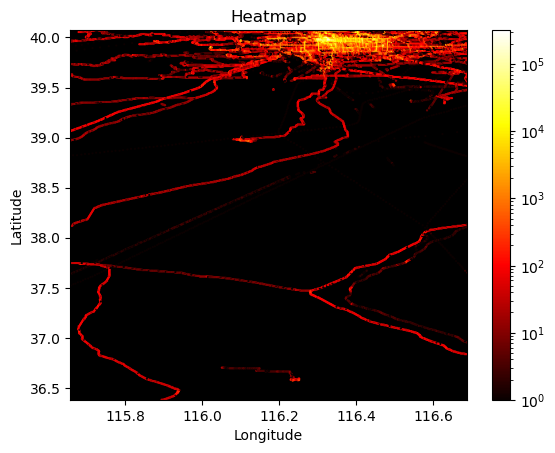

In [5]:
# Import visualisation
from stg.utils.visualise import heatmap
# Heatmap of the 90% Bounding Box
quantile = 0.9
bbox = find_bbox(geolife_unprocessed_points, quantile)

heatmap(geolife_unprocessed_points,bbox=bbox)

Therefore, we manually define a bounding box around Beijing based on geographical knowledge.
In particular, we consider the 5th ring road around Beijing as the outer boundary of the bounding box.
The fourth or fifth ring road has been used by other researchers as the boundary of Beijing.
We decided for the fifth ring road as this excludes less data points.


### Fifth Ring Road

BBOX of Fifth Ring Road:	(116.19, 116.56, 39.75, 40.03)


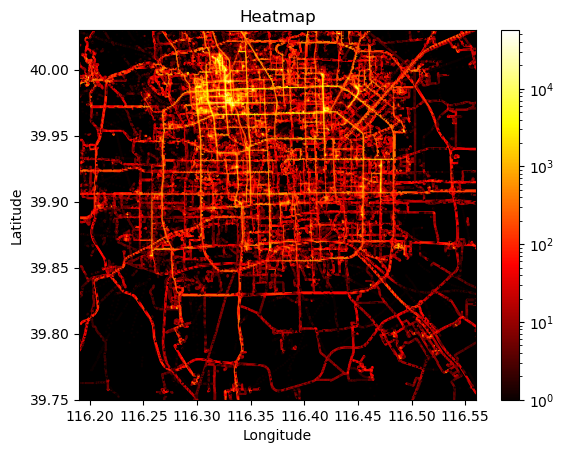

In [6]:
bbox_name = "FIFTH-RING"
bbox = gl.GL_BBOXES['FIFTH-RING']
print(f"BBOX of Fifth Ring Road:\t{bbox}")

# Plot Heatmap
_ = heatmap(geolife_unprocessed_points,bbox=bbox)

This looks much more useful.
Therefore, we will update the trajectories now.

In [7]:
tasks = ((t,*bbox, 'lat', 'lon', False) for t in geolife_unprocessed_list)
# Multiprocessing code
# with mp.Pool() as pool:
#     geolife_in_bbox = [t for t in pool.starmap(pp.drop_out_of_bounds, tasks)]
# Single core code
geolife_in_bbox = [pp.drop_out_of_bounds(*t) for t in tqdm(tasks, total=len(geolife_unprocessed_list)) if len(t) > 0]
n_in_bbox = len(pd.concat(geolife_in_bbox))
print(f"Number of Points after dropping out of BBOX:\t{n_in_bbox:,} ({n_in_bbox / n_unprocessed * 100:.2f}%)")

  0%|          | 0/18670 [00:00<?, ?it/s]

Number of Points after dropping out of BBOX:	16,455,443 (66.15%)


## Granularity

The dataset contains a lot of points, some them being duplicates or erroneous GPS readings.
Removing duplicates is not trivial: 
- If two points have the same timestamp, we cannot know which one is the correct one. We could guess based on the distance to the surrounding points, but what if these are also duplicates?
- Moreover, the process is very slow as whenever we remove a point, we need to check the surrounding points again.

Moreover, we want to consider simple models that might not take the timestamps into account. In that case, the model will struggle to learn the sequential properties, as two points that have been recorded in 2s intervals are naturally much closer than two points that have been recorded in 2h intervals.
Therefore, we will try to even the granularity of the dataset by resampling the trajectories to a fixed interval.
According to the documentation: " 91 percent of the trajectories are logged in a dense representation, e.g. every 1\~5 seconds or every 5\~10 meters per point."

Therefor, we decided to resample the trajectories to 5s intervals.

In [8]:
SAMPLING_RATE = 5  # seconds
parallelize = True
LOAD = False
chunksize = 100
resampled_filepath = config.BASE_DIR + f"data/geolife_resampled_{bbox_name}_{SAMPLING_RATE}.csv"


start_time = timer()
if LOAD:
    df = pd.read_csv(resampled_filepath,
                     dtype={'tid': str, 'uid': 'int32', 'timestamp': str},
                     parse_dates=['timestamp']
                     )
    geolife_resampled = [traj.reset_index(drop=True) for tid, traj in df.groupby('tid')]
    # Sort by uid first and tid second
    geolife_resampled.sort(key=lambda x: (x['uid'].iloc[0], x['tid'].iloc[0]))
else:
    if parallelize:
        tasks = ((t, SAMPLING_RATE) for t in geolife_in_bbox)
        def wrapper(t):
            return pp.resample_trajectory(*t)
        # Multiprocessing code with tqdm progress bar
        geolife_resampled = []
        with mp.Pool() as pool:
            with tqdm(total=len(geolife_in_bbox)) as pbar:
                for t in pool.imap_unordered(wrapper, tasks, chunksize=chunksize):
                    if len(t) > 0:
                        geolife_resampled.append(t)
                    pbar.update()
    else:
        # Single core code
        geolife_resampled = [pp.resample_trajectory(t, SAMPLING_RATE) for t in tqdm(geolife_in_bbox, total=len(geolife_in_bbox),leave=False)]
    # Compute time in format mm:ss
    time_string = f"{(timer() - start_time) // 60:.0f}:{(timer() - start_time) % 60:02.0f}"
    print(f"Time required:\t\t\t\t\t{time_string}min")

geolife_resampled_df = pd.concat(geolife_resampled)
n_resampled = len(geolife_resampled_df)
print(f"Number of Points after resampling to {SAMPLING_RATE}s:\t\t{n_resampled:,} ({n_resampled / n_unprocessed * 100:.2f}%)")
print(f"Number of Trajectories after resampling to {SAMPLING_RATE}s:\t{len(geolife_resampled):,} ({len(geolife_resampled) / len(geolife_unprocessed_list) * 100:.2f}%)")

Number of Points after resampling to 5s:		8,598,197 (34.56%)
Number of Trajectories after resampling to 5s:	16,489 (88.32%)


This part of the pre-processing is fairly slow.
We found that the chunksize matters.
Some guidelines based on our evaluation system which is a server running Ubuntu 20.04.01 LTS,  contains 2x Intel Xeon Silver 4208 (16 physical cores and 32 virtual threads) and contains $128 \, \text{GB}$ RAM:
- `chunksize=1`: $>20\,min$ (aborted)
- `chunksize=10`: $9:07\,min$
- `chunksize=100`: $9:27\,min$
- `chunksize=1000`: $17:04\,min$


In [9]:
# Check that the correct number of trajectories has been resampled
assert len(geolife_resampled) == 16489, f"Number of trajectories is incorrect. Expected 16489. Got {len(geolife_resampled)}."
# Check that the correct number of points has been resampled
assert n_resampled == 8598197, f"Number of points is incorrect. Expected 8,598,197. Got {n_resampled}."
# Check 182 users
assert max(geolife_resampled_df['uid']) == 181, f"Number of users is incorrect. Expected 181. Got {len(geolife_resampled_df['uid'].unique())}."
assert len(geolife_resampled_df['uid'].unique()) == 179, f"Number of users is incorrect. Expected 179. Got {len(geolife_resampled_df['uid'].unique())}."

In [10]:
STORE = True
# Store the resampled trajectories into a file as the resampling takes a long time
if STORE and not LOAD:
    # Create one huge dataframe
    geolife_resampled_df = pd.concat(geolife_resampled)
    # Store the dataframe
    geolife_resampled_df.to_csv(resampled_filepath, index=False)

## Split on Breaks

Some Trajectories might span large periods of time, including long breaks.
This breaks the regular granularity we have just created through resampling.
While we would like to accommodate for shorter breaks caused by irregular sensors, we split trajectories exceeding a certain break length.

In [11]:
MAXIMAL_BREAK_INTERVAL = 60  # seconds

# Split trajectories on breaks
geolife_resampled_split = []
for i, t in tqdm(enumerate(geolife_resampled), total=len(geolife_resampled)):
    splits = pp.split_and_rename(t, interval=MAXIMAL_BREAK_INTERVAL, max_len=None)
    geolife_resampled_split.extend(splits)

geolife_split_df = pd.concat(geolife_resampled_split)
n_resampled_split = len(geolife_split_df)
print(f"Number of Points after splitting at {MAXIMAL_BREAK_INTERVAL}s:\t\t{n_resampled_split:,} ({n_resampled_split / n_unprocessed * 100:.2f}%)")
print(f"Number of Trajectories after splitting at {MAXIMAL_BREAK_INTERVAL}s:\t{len(geolife_resampled_split):,} ({len(geolife_resampled_split) / len(geolife_unprocessed_list) * 100:.2f}%)")

  0%|          | 0/16489 [00:00<?, ?it/s]

Number of Points after splitting at 60s:		8,598,197 (34.56%)
Number of Trajectories after splitting at 60s:	102,484 (548.92%)


## Maximal Length

Next, we have to consider the trajectories' lengths.
The dataset contains trajectories of varying lengths, including very long trajectories.
As a lower bound, we use a trajectory length of 10 points, as this represents a reasonable length for information to be extracted from the trajectory and has been used by other researchers.
The upper bound is more difficult to determine.
In theory, the optimal length would be the length of the longest trajectory in the dataset.
However, this would result in a huge amount of padding being required, which makes the training process infeasible.
Apart from that, sequential models such as RNNs and LSTMs struggle with long sequences due to error propagation.
First, we examine the distribution of the trajectory lengths. 

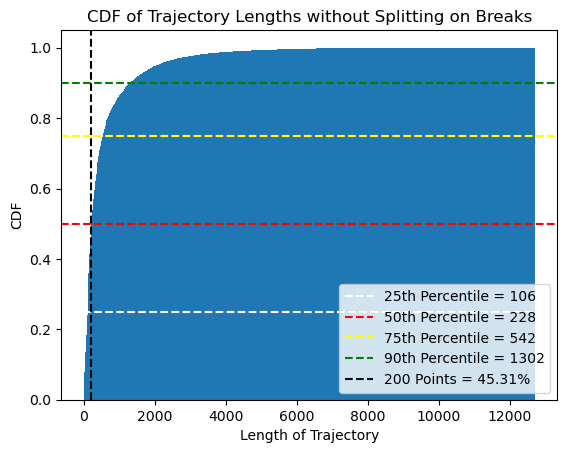

In [12]:
from pathlib import Path
from stg import config
import matplotlib.pyplot as plt

# Without splitting on breaks
# ########################################
# Plot CDF containing all lengths of remaining trajectories
lengths = [len(t) for t in geolife_resampled]
plt.hist(lengths, bins=500, cumulative=True, density=True)
# Add Lines (including labels) at 25, 50, 75 and 90 percentiles
percentiles = [25, 50, 75, 90]
colors = ['white', 'red', 'yellow', 'green']
for i, p in enumerate(percentiles):
    plt.axhline(p / 100, color=colors[i], linestyle='--', label=f"{p}th Percentile = {np.percentile(lengths, p):.0f}")
# Vertical lines at 200 and compute percentage of trajectories that are shorter than 200 points
plt.axvline(200, color='black', linestyle='--', label=f"200 Points = {len([l for l in lengths if l < 200]) / len(lengths) * 100:.2f}%")
plt.legend(loc='lower right')
plt.xlabel("Length of Trajectory")
plt.ylabel("CDF")
plt.title("CDF of Trajectory Lengths without Splitting on Breaks")
# plt.show()
Path(config.BASE_DIR + "plot/").mkdir(parents=True, exist_ok=True)
plt.savefig(config.BASE_DIR + "plot/geolife_length_cdf_without_prev_time_split.png", dpi=300)

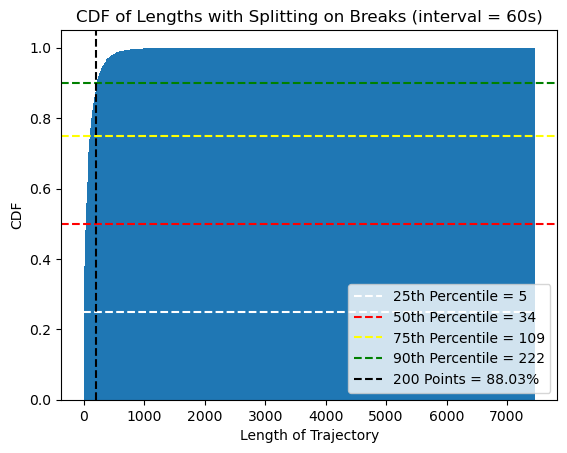

In [13]:
# Repeat for trajectories that have been split on breaks
# ########################################
# Plot CDF containing all lengths of remaining trajectories
lengths = [len(t) for t in geolife_resampled_split]
plt.hist(lengths, bins=500, cumulative=True, density=True)
# Add Lines (including labels) at 25, 50, 75 and 90 percentiles
percentiles = [25, 50, 75, 90]
colors = ['white', 'red', 'yellow', 'green']
for i, p in enumerate(percentiles):
    plt.axhline(p / 100, color=colors[i], linestyle='--', label=f"{p}th Percentile = {np.percentile(lengths, p):.0f}")
# Vertical lines at 200 and compute percentage of trajectories that are shorter than 200 points
plt.axvline(200, color='black', linestyle='--', label=f"200 Points = {len([l for l in lengths if l < 200]) / len(lengths) * 100:.2f}%")
plt.legend(loc='lower right')
plt.xlabel("Length of Trajectory")
plt.ylabel("CDF")
plt.title("CDF of Lengths with Splitting on Breaks (interval = 60s)")
# plt.show()
Path(config.BASE_DIR + "plot/").mkdir(parents=True, exist_ok=True)
plt.savefig(config.BASE_DIR + "plot/geolife_length_cdf.png", dpi=300)

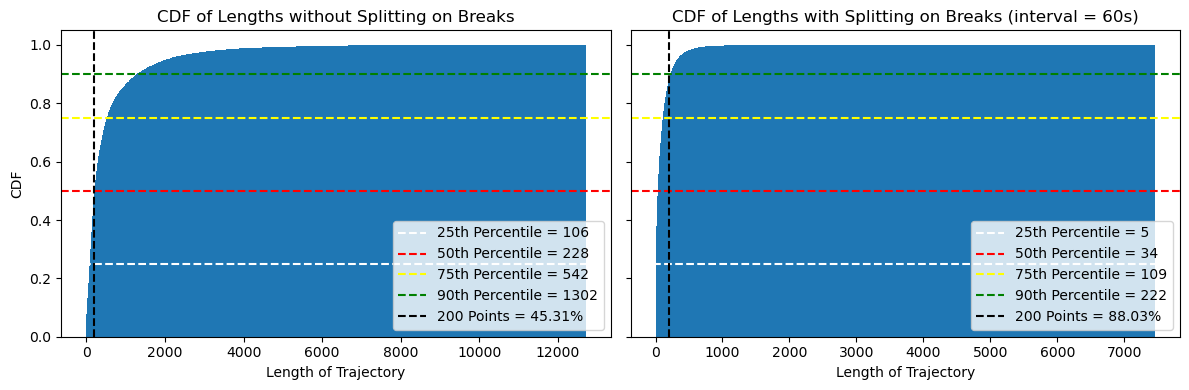

In [14]:
# Plot both figures next to each other
# ########################################
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# Without splitting on breaks
# ########################################
# Plot CDF containing all lengths of remaining trajectories
lengths = [len(t) for t in geolife_resampled]
ax1.hist(lengths, bins=500, cumulative=True, density=True)
# Add Lines (including labels) at 25, 50, 75 and 90 percentiles
percentiles = [25, 50, 75, 90]
colors = ['white', 'red', 'yellow', 'green']
for i, p in enumerate(percentiles):
    ax1.axhline(p / 100, color=colors[i], linestyle='--', label=f"{p}th Percentile = {np.percentile(lengths, p):.0f}")
# Vertical lines at 200 and compute percentage of trajectories that are shorter than 200 points
ax1.axvline(200, color='black', linestyle='--', label=f"200 Points = {len([l for l in lengths if l < 200]) / len(lengths) * 100:.2f}%")
ax1.legend(loc='lower right')
ax1.set_xlabel("Length of Trajectory")
ax1.set_ylabel("CDF")
ax1.set_title("CDF of Lengths without Splitting on Breaks")

# Repeat for trajectories that have been split on breaks
# ########################################
# Plot CDF containing all lengths of remaining trajectories
lengths = [len(t) for t in geolife_resampled_split]
ax2.hist(lengths, bins=500, cumulative=True, density=True)
# Add Lines (including labels) at 25, 50, 75 and 90 percentiles
percentiles = [25, 50, 75, 90]
colors = ['white', 'red', 'yellow', 'green']
for i, p in enumerate(percentiles):
    ax2.axhline(p / 100, color=colors[i], linestyle='--', label=f"{p}th Percentile = {np.percentile(lengths, p):.0f}")
# Vertical lines at 200 and compute percentage of trajectories that are shorter than 200 points
ax2.axvline(200, color='black', linestyle='--', label=f"200 Points = {len([l for l in lengths if l < 200]) / len(lengths) * 100:.2f}%")
ax2.legend(loc='lower right')
ax2.set_xlabel("Length of Trajectory")
# ax2.set_ylabel("CDF")
ax2.set_title("CDF of Lengths with Splitting on Breaks (interval = 60s)")

plt.tight_layout()
# plt.show()
Path(config.BASE_DIR + "plot/").mkdir(parents=True, exist_ok=True)
plt.savefig(config.BASE_DIR + "plot/geolife_length_cdf_combined.png", dpi=300)

We decided that using *200 points* appears to be a reasonable upper bound due to the fact that it is an even number covering almost 50% of trajectories without splits and nearly 90% if splits are used.
Now, we have three options:
1. We could remove all trajectories that are longer than 200 points.
    + *Advantage:* This allows for instance-level privacy for all remaining trajectories.
    - *Disadvantage:* Significant amount of data is lost.
2. We could truncate all trajectories to 200 points.
    + *Advantage:* This allows for instance-level privacy for all remaining trajectories.
    - *Disadvantage:* Some trajectories might not be meaningful after truncation.
3. We could split all trajectories into multiple trajectories of 200 points or fewer.
    + *Advantage:* Nearly no data is lost (only if a split results in a trajectory of less than 10 points).
    - *Disadvantage:* The privacy guarantee is reduced to $k \varepsilon$-differential privacy, where $k$ is the maximal number of splits used for any trajectory.


In [15]:
from stg.datasets.geolife import TrajectoryLength

# Choose the option
LENGTH_METHOD = TrajectoryLength.TRUNCATE
MAX_LEN = 200

pb = tqdm(geolife_resampled_split, total=len(geolife_resampled_split), desc="Splitting trajectories")

if LENGTH_METHOD == TrajectoryLength.REMOVE:
    # Remove trajectories that are longer than 200 points
    geolife_upper_bounded = [t.reset_index(drop=True) for t in pb if len(t) <= MAX_LEN]
elif LENGTH_METHOD == TrajectoryLength.TRUNCATE:
    # Truncate trajectories to MAX_LEN points
    geolife_upper_bounded = [t[:MAX_LEN].reset_index(drop=True) for t in pb]
elif LENGTH_METHOD == TrajectoryLength.SPLIT:
    # Split trajectories into multiple trajectories of MAX_LEN points or fewer
    geolife_upper_bounded = []
    for t in pb:
        splits = pp.split_and_rename(t, interval=None, max_len=MAX_LEN)
        geolife_upper_bounded.extend(splits)
else:
    raise ValueError("Invalid Trajectory Length Method")

geolife_upper_bounded_df = pd.concat(geolife_upper_bounded)
n_upper_bounded = len(geolife_upper_bounded_df)
print(f"Number of Points after upper bounding (via {LENGTH_METHOD.name}) to 200 points:\t\t\t{n_upper_bounded:,} ({n_upper_bounded / n_unprocessed * 100:.2f}%)")
print(f"Number of Trajectories after upper bounding (via {LENGTH_METHOD.name}) to 200 points:\t{len(geolife_upper_bounded):,} ({len(geolife_upper_bounded) / len(geolife_unprocessed_list) * 100:.2f}%)")

Splitting trajectories:   0%|          | 0/102484 [00:00<?, ?it/s]

Number of Points after upper bounding (via TRUNCATE) to 200 points:			6,587,529 (26.48%)
Number of Trajectories after upper bounding (via TRUNCATE) to 200 points:	102,484 (548.92%)


## Removing the too short trajectories

As explained above, we remove all trajectories that are shorter than 10 points.

In [16]:
MIN_LEN = 10
geolife_final = [t for t in geolife_upper_bounded if len(t) >= MIN_LEN]

geolife_final_df = pd.concat(geolife_final)
n_final = len(geolife_final_df)
print(f"Final Number of Points:\t\t\t{n_final:,} ({n_final / n_unprocessed * 100:.2f}%)")
print(f"Final Number of Trajectories:\t{len(geolife_final):,} ({len(geolife_final) / len(geolife_unprocessed_list) * 100:.2f}%)")

Final Number of Points:			6,486,421 (26.07%)
Final Number of Trajectories:	69,504 (372.28%)


## Storage

Write trajectories to a file.

In [17]:
STORE = False
OUTPUT_FILE = config.BASE_DIR + f"data/{gl.get_filename(bbox_name, SAMPLING_RATE, MAXIMAL_BREAK_INTERVAL, MAX_LEN, LENGTH_METHOD)}.csv"
OUTPUT_DIR = config.BASE_DIR + f"data/{gl.get_filename(bbox_name, SAMPLING_RATE, MAXIMAL_BREAK_INTERVAL, MAX_LEN, LENGTH_METHOD)}/"
# Store the final trajectories into a file.
if STORE:
    # Sort by uid first and tid second
    geolife_final.sort(key=lambda x: (x['uid'].iloc[0], x['tid'].iloc[0]))
    # Store the dataframe
    geolife_final_df.to_csv(OUTPUT_FILE, index=False)
    # Store into separate files for each trajectory
    Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)
    for i, t in tqdm(enumerate(geolife_final), total=len(geolife_final), desc="Storing Trajectories"):
        tid = f"{t['tid'].iloc[0]}"
        t.to_csv(OUTPUT_DIR + f"{tid}.csv", index=False)
print(f"Saved to {OUTPUT_FILE} and {OUTPUT_DIR}.")

Saved to /home/erik/project2/data/geolife_FIFTH-RING_5_60_200_TRUNCATE.csv and /home/erik/project2/data/geolife_FIFTH-RING_5_60_200_TRUNCATE/.


## Loading

Measure how long the two variants take to load from the file.

In [18]:
# %%timeit
start = timer()
geolife_loaded_df = pd.read_csv(OUTPUT_FILE,
                 dtype={'tid': str, 'uid': 'int32', 'timestamp': str},
                 parse_dates=['timestamp']
                 )
geolife_loaded = [traj.reset_index(drop=True) for tid, traj in geolife_loaded_df.groupby('tid')]
# Sort by uid first and tid second
geolife_loaded.sort(key=lambda x: (x['uid'].iloc[0], x['tid'].iloc[0]))
# Print time in seconds
print(f"Time required:\t\t\t\t\t{(timer() - start):.2f}s")

Time required:					23.68s


**Result:** 16.3 s ± 152 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

In [19]:
# Compare the loaded and the original for equality
# 1. Sort the original by uid first and tid second
geolife_final.sort(key=lambda x: (x['uid'].iloc[0], x['tid'].iloc[0]))
# 2. Compare the two lists
for i, (t1, t2) in enumerate(zip(geolife_final, geolife_loaded)):
    if not t1.equals(t2):
        print(f"Trajectory {i} is not equal.")
        
        print("Final: \n", t1.head())
        print("Loaded: \n", t2.head())
        
        break
else:
    print("All trajectories are equal.")

All trajectories are equal.


## Determine Reference Point and Scaling Factor

In [20]:
from stg.utils.helpers import get_ref_point, get_scaling_factor

# Determine reference point
ref_point = get_ref_point(geolife_final_df[['lat', 'lon']])
print(f"Reference Point:\t{ref_point}")

# Determine scaling factor
scaling_factor = get_scaling_factor(geolife_final_df[['lat', 'lon']], ref_point)
print(f"Scaling Factor:\t\t{scaling_factor}")

Reference Point:	[ 39.89000165 116.37499995]
Scaling Factor:		[0.13999835 0.18499995]


Run the GeoLife Unittest to verify that everything ran correctly.
These are skipped by default due to the time it takes to run. You can enable them by setting `RUN_SLOW_TESTS=true`.
```bash
RUN_SLOW_TESTS=true python -m unittest test.test_geolife
```

## PyTorch Dataset

In [21]:
from stg.datasets.geolife import GeoLifeDataset, DatasetModes

gl_data = GeoLifeDataset(DatasetModes.ALL, keep_original=True, return_labels=False)
print(f"Number of Trajectories:\t\t\t{len(gl_data):,}")
print(f"Number of Points:\t\t\t\t{sum([len(t) for t in gl_data]):,}")

Make sure the reference point and scale factor computed during pre-processing are used!


Number of Trajectories:			69,504
Number of Points:				6,486,421
